# Assignment 1: Predict diabetes using Perceptron
## 1 Load the dataset

In [1]:
# Import
import numpy as np
import pandas as pd
import requests
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import torch
from torch import nn
import torch.optim as optim

from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
def set_seed(seed_value):
    # Set seed for PyTorch
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    
    # Set seed for Python random module
    random.seed(seed_value)
    
    # Set seed for numpy random module
    np.random.seed(seed_value)

# Call set_seed function at the beginning of your code
set_seed(33)

In [3]:
# Function to load and parse LIBSVM format data
def load_libsvm_data(url):
    # Download the dataset
    response = requests.get(url)
    
    # Check if the download was successful
    if response.status_code != 200:
        raise Exception("Failed to download data")
    
    # LIBSVM format: the first column is the label, the rest are features in index:value format
    data = response.text.strip().split('\n')
    
    labels = []
    features = []
    
    # Parse each line
    for row in data:
        row = row.split()
        label = int(row[0])  # first column is the label
        feature_dict = {}
        
        # Extract index:value pairs
        for feature in row[1:]:
            index, value = feature.split(":")
            feature_dict[int(index)] = float(value)
        
        labels.append(label)
        features.append(feature_dict)
    
    # Convert to pandas DataFrame (missing features will have NaN values)
    df = pd.DataFrame(features)
    df.fillna(0, inplace=True)  # Replace NaN with 0 for missing features
    labels = np.array(labels)  # Convert labels to a numpy array
    
    return df, labels

In [4]:
# URL for the dataset
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes'

# Load the data
X, y = load_libsvm_data(url)

# Convert labels: map -1 to 0
y = np.where(y == -1, 0, 1)

In [5]:
# Display first 5 labels in the dataset
print("Labels:")
print(y[:5])

# Display the first 5 rows to verify the loading process
print("First 5 rows of the dataset:")
X.head()

Labels:
[0 1 0 1 0]
First 5 rows of the dataset:


,1,2,3,4,5,6,7,8
0,6.0,148.0,72.0,35.0,0.0,33.599998,0.627,50.0
1,1.0,85.0,66.0,29.0,0.0,26.600000,0.351,31.0
2,8.0,183.0,64.0,0.0,0.0,23.299999,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.100000,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.099998,2.288,33.0


## 2 Split and Display

In [6]:
# Display key information about the dataset
print("Dataset Summary:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Unique labels: {np.unique(y)}")

Dataset Summary:
Number of samples: 768
Number of features: 8
Unique labels: [0 1]


In [7]:
# Stratified splitting to maintain the same class distribution across train, val, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)  # 60% train, 40% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)  # 20% val, 20% test

# Create combined training and validation sets
X_train_combined = np.vstack((X_train, X_val))
y_train_combined = np.concatenate((y_train, y_val))

# Print the class distribution before balancing
print("\nClass distribution before balancing:")
print("Training set:", Counter(y_train), 'Total:', len(y_train))
print("Validation set:", Counter(y_val), 'Total:', len(y_val))
print("Combined set (train + val):", Counter(y_train_combined), 'Total:', len(y_train_combined)) # For final model training
print("Test set:", Counter(y_test), 'Total:', len(y_test))


Class distribution before balancing:
Training set: Counter({1: 299, 0: 161}) Total: 460
Validation set: Counter({1: 101, 0: 53}) Total: 154
Combined set (train + val): Counter({1: 400, 0: 214}) Total: 614
Test set: Counter({1: 100, 0: 54}) Total: 154


In [8]:
# Apply SMOTE only to the training set to balance classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Apply SMOTE only to the training set to balance classes
smote = SMOTE(random_state=42)
X_train_combined_balanced, y_train_combined_balanced = smote.fit_resample(X_train_combined, y_train_combined)

# Print the class distribution after SMOTE balancing
print("Class distribution after balancing:")
print("Balanced Training set:", Counter(y_train_balanced))
print("Validation set (unchanged):", Counter(y_val))
print("Combined set (train + val):", Counter(y_train_combined_balanced)) # For final model training
print("Test set (unchanged):", Counter(y_test))

Class distribution after balancing:
Balanced Training set: Counter({1: 299, 0: 299})
Validation set (unchanged): Counter({1: 101, 0: 53})
Combined set (train + val): Counter({1: 400, 0: 400})
Test set (unchanged): Counter({1: 100, 0: 54})


In [9]:
# Initialize scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_balanced = scaler.fit_transform(X_train_balanced)

# Transform the data
X_val = scaler.transform(X_val)
X_train_combined_balanced = scaler.transform(X_train_combined_balanced)
X_test = scaler.transform(X_test)

## 3 Train model

In [10]:
# Set a random seed for reproducibility
torch.manual_seed(33)
np.random.seed(33)

# Define the Perceptron model
class Perceptron(nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))


# Function to get optimizers
def get_optimizers(model, lr):
    return {
        "SGD": optim.SGD(model.parameters(), lr=lr),
        "Adam": optim.Adam(model.parameters(), lr=lr),
        "RMSprop": optim.RMSprop(model.parameters(), lr=lr)
    }

def evaluate_perceptron_with_optimizers(X_train, y_train, X_val, y_val, lr, reg, optimizer_name):
    input_size = X_train.shape[1]
    model = Perceptron(input_size=input_size)

    optimizer = get_optimizers(model, lr)[optimizer_name]
    criterion = nn.BCELoss()
    model.train()

    num_epochs = 100
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(torch.tensor(X_train, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(y_train, dtype=torch.float32).view(-1, 1)) + reg * sum(p.pow(2).sum() for p in model.parameters())
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        with torch.no_grad():
            train_preds = (outputs > 0.5).float()
            train_accuracy = (train_preds.view(-1).numpy() == y_train).mean()
            train_accuracies.append(train_accuracy)

            val_outputs = model(torch.tensor(X_val, dtype=torch.float32))
            val_loss = criterion(val_outputs, torch.tensor(y_val, dtype=torch.float32).view(-1, 1))
            val_losses.append(val_loss.item())

            val_preds = (val_outputs > 0.5).float()
            val_accuracy = (val_preds.view(-1).numpy() == y_val).mean()
            val_accuracies.append(val_accuracy)

    # Compute final validation accuracy
    final_val_accuracy = val_accuracies[-1] if val_accuracies else 0.0

    # Return a structured dictionary with results including final accuracy
    return {
        'Learning Rate': lr,
        'Regularization': reg,
        'Optimizer': optimizer_name,
        'Train Loss': train_losses,
        'Validation Loss': val_losses,
        'Train Accuracy': train_accuracies,
        'Validation Accuracy': val_accuracies,
        'Final Validation Accuracy': final_val_accuracy  # Add final accuracy
    }


### 3.1 Baseline Model

I have chosen my baseline model to use a basic SGD, a moderate learning rate of 0.01, no regularization and 100 epochs.

In [11]:
# Define an empty DataFrame to store the baseline result
baseline_df = pd.DataFrame()

# Run the baseline model using the correct function call
baseline_accuracy = evaluate_perceptron_with_optimizers(
    X_train_balanced, 
    y_train_balanced, 
    X_val, 
    y_val, 
    lr=0.01,  # Correctly using lr keyword argument
    reg=0, 
    optimizer_name="SGD") 

# Convert the list of dictionaries to a DataFrame
baseline_accuracy_df = pd.DataFrame([baseline_accuracy])

# Print baseline accuracy DataFrame
print("\nBaseline Model Results:")
selected_columns = ['Learning Rate', 'Regularization', 'Optimizer', 'Final Validation Accuracy']
baseline_accuracy_df[selected_columns]


Baseline Model Results:


,Learning Rate,Regularization,Optimizer,Final Validation Accuracy
0,0.01,0,SGD,0.681818


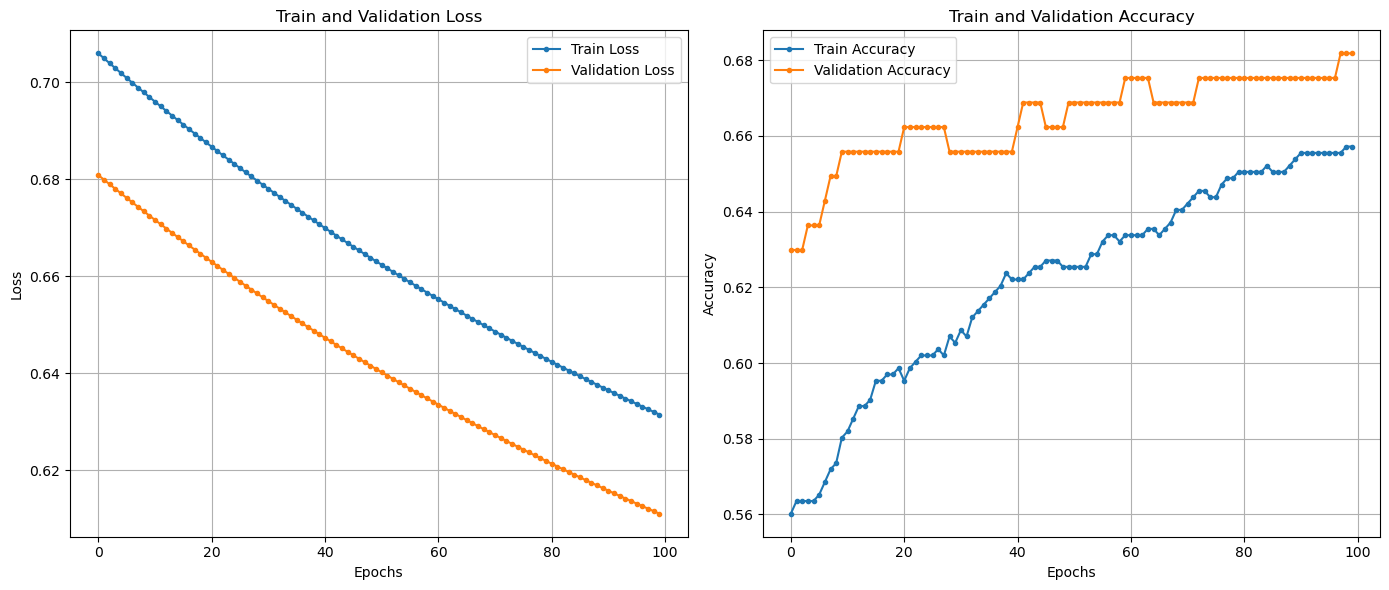

In [12]:
# Extract data from the DataFrame
train_losses = baseline_accuracy_df['Train Loss'].iloc[0]  # Assuming you have a single row
val_losses = baseline_accuracy_df['Validation Loss'].iloc[0]
train_accuracies = baseline_accuracy_df['Train Accuracy'].iloc[0]
val_accuracies = baseline_accuracy_df['Validation Accuracy'].iloc[0]

# Create a figure with subplots for Loss and Accuracy (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Loss
ax1.plot(train_losses, label='Train Loss', marker='.')
ax1.plot(val_losses, label='Validation Loss', marker='.')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid()

# Plot Accuracy
ax2.plot(train_accuracies, label='Train Accuracy', marker='.')
ax2.plot(val_accuracies, label='Validation Accuracy', marker='.')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### 3.2 Hyperparameter Tuning (LR, Regularization, Optimizer)

In [13]:
# Set a random seed for reproducibility
torch.manual_seed(33)
np.random.seed(33)

# Main loop to test all optimizers, learning rates, and regularization rates
results_list = []

learning_rates = [0.001, 0.01, 0.1]
regularization_rates = [0.0, 0.01, 0.1]

input_size = X_train.shape[1]

for lr in learning_rates:
    for reg in regularization_rates:
        # Get optimizers for the current learning rate
        optimizers = get_optimizers(Perceptron(input_size=input_size), lr)
        
        for optimizer_name, optimizer in optimizers.items():
            result = evaluate_perceptron_with_optimizers(
                X_train_balanced, 
                y_train_balanced, 
                X_val, 
                y_val, 
                lr, 
                reg, 
                optimizer_name
            )
            results_list.append(result)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)


In [14]:
# Sort the results DataFrame by 'Final Validation Accuracy' in descending order
sorted_results_df = results_df.sort_values(by='Final Validation Accuracy', ascending=False).reset_index(drop=True)

# Select the columns to display
selected_columns = ['Learning Rate', 'Regularization', 'Optimizer', 'Final Validation Accuracy']
print("\nAll Results (Sorted by Final Validation Accuracy):")
sorted_results_df[selected_columns]


All Results (Sorted by Final Validation Accuracy):


,Learning Rate,Regularization,Optimizer,Final Validation Accuracy
0,0.100,0.01,SGD,0.785714
1,0.100,0.10,RMSprop,0.772727
2,0.100,0.01,RMSprop,0.772727
3,0.001,0.01,RMSprop,0.766234
4,0.100,0.01,Adam,0.766234
5,0.010,0.00,Adam,0.766234
6,0.100,0.00,RMSprop,0.759740
7,0.100,0.00,Adam,0.759740
8,0.100,0.00,SGD,0.759740
9,0.001,0.00,Adam,0.759740


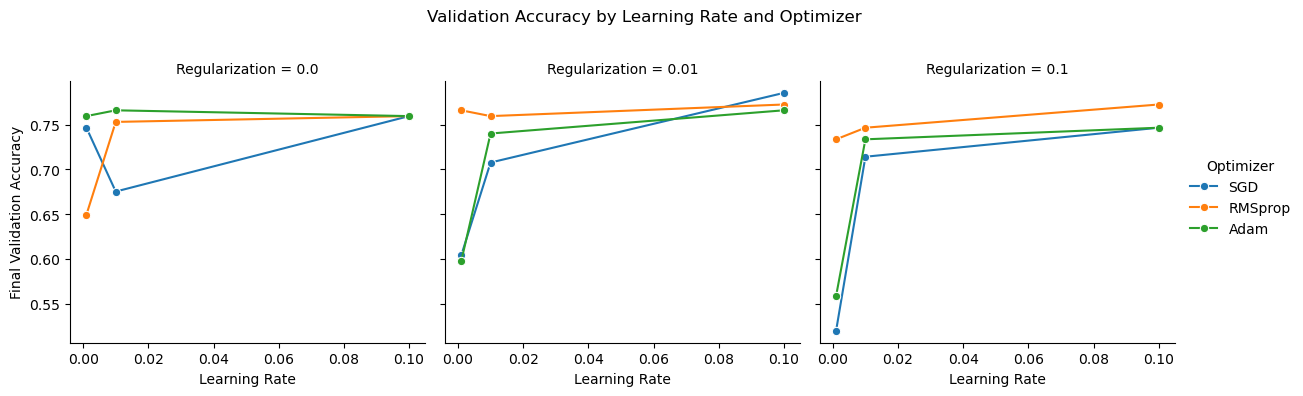

In [15]:
# Facet Grid
g = sns.FacetGrid(sorted_results_df[selected_columns], col="Regularization", hue="Optimizer", 
                  col_wrap=3, height=4, aspect=1)
g.map(sns.lineplot, "Learning Rate", "Final Validation Accuracy", marker='o')
g.add_legend()
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Validation Accuracy by Learning Rate and Optimizer')
plt.show()

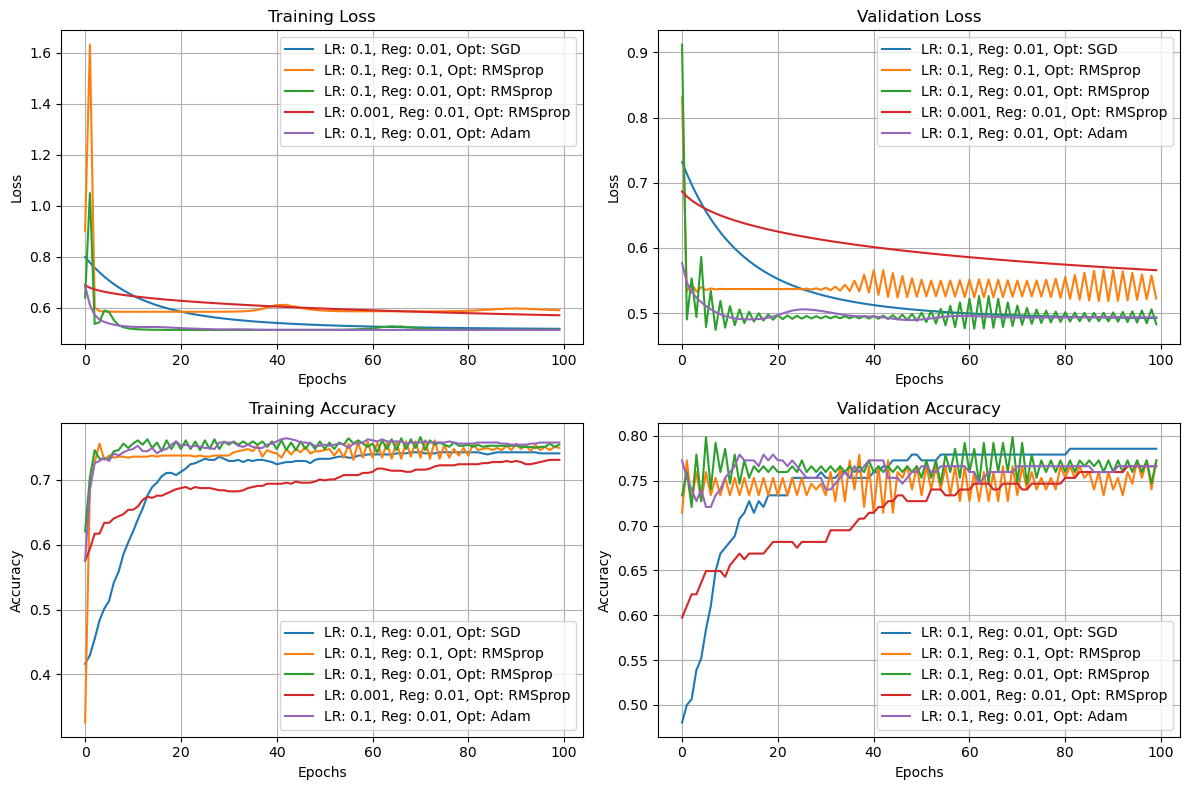

In [16]:
# Select the first 5 models from the sorted results
selected_results = sorted_results_df.head(5)

# Initialize the figure and axes for 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot Training Loss
for index, row in selected_results.iterrows():
    axes[0, 0].plot(row['Train Loss'], label=f"LR: {row['Learning Rate']}, Reg: {row['Regularization']}, Opt: {row['Optimizer']}")
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid()

# Plot Validation Loss
for index, row in selected_results.iterrows():
    axes[0, 1].plot(row['Validation Loss'], label=f"LR: {row['Learning Rate']}, Reg: {row['Regularization']}, Opt: {row['Optimizer']}")
axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid()

# Plot Training Accuracy
for index, row in selected_results.iterrows():
    axes[1, 0].plot(row['Train Accuracy'], label=f"LR: {row['Learning Rate']}, Reg: {row['Regularization']}, Opt: {row['Optimizer']}")
axes[1, 0].set_title('Training Accuracy')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid()

# Plot Validation Accuracy
for index, row in selected_results.iterrows():
    axes[1, 1].plot(row['Validation Accuracy'], label=f"LR: {row['Learning Rate']}, Reg: {row['Regularization']}, Opt: {row['Optimizer']}")
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid()

# Adjust layout
plt.tight_layout()
plt.savefig('HyperparameterTuning.png')
plt.show()

In [17]:
# Identify the best model configuration based on validation accuracy
best_model_idx = sorted_results_df['Final Validation Accuracy'].idxmax()
best_params = sorted_results_df.loc[best_model_idx]

best_learning_rate = best_params['Learning Rate']
best_regularization = best_params['Regularization']
best_optimizer_name = best_params['Optimizer']
best_validation_accuracy = best_params['Final Validation Accuracy']

# Print the best model parameters
print(f"Best Model Parameters: Learning Rate={best_learning_rate}, Regularization={best_regularization}, Optimizer={best_optimizer_name}, Validation Accuracy={best_validation_accuracy:.4f}")

Best Model Parameters: Learning Rate=0.1, Regularization=0.01, Optimizer=SGD, Validation Accuracy=0.7857


## 4 Results

In [18]:
# Set a random seed for reproducibility
torch.manual_seed(33)
np.random.seed(33)

# Initialize the Perceptron model
best_model = Perceptron(input_size)

# Combine the training and validation data into PyTorch tensors
X_combined_tensor = torch.tensor(X_train_combined_balanced, dtype=torch.float32)
y_combined_tensor = torch.tensor(y_train_combined_balanced, dtype=torch.float32).view(-1, 1)  # Reshape for binary output

# Get the optimizer based on the best found parameters
optimizer = get_optimizers(best_model, best_learning_rate)[best_optimizer_name]  # Use the best optimizer

# Training the model
criterion = nn.BCELoss()  # Binary Cross Entropy loss for binary classification
best_model.train()

# Number of epochs for training
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    optimizer.zero_grad()  # Zero the gradients
    outputs = best_model(X_combined_tensor)  # Forward pass
    loss = criterion(outputs, y_combined_tensor) + best_regularization * sum(p.pow(2).sum() for p in best_model.parameters())  # Add L2 regularization
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    # Store training loss
    train_losses.append(loss.item())

    # Calculate training accuracy
    with torch.no_grad():
        y_train_pred_probs = best_model(X_combined_tensor)
        y_train_pred = (y_train_pred_probs > 0.5).float()  # Convert probabilities to binary predictions
        train_accuracy = accuracy_score(y_combined_tensor.numpy(), y_train_pred.numpy())
        train_accuracies.append(train_accuracy)

    # Validation phase
    with torch.no_grad():
        val_outputs = best_model(torch.tensor(X_val, dtype=torch.float32))
        val_loss = criterion(val_outputs, torch.tensor(y_val, dtype=torch.float32).view(-1, 1))  # Calculate validation loss
        val_losses.append(val_loss.item())

        # Calculate validation accuracy
        y_val_pred = (val_outputs > 0.5).float()  # Convert probabilities to binary predictions
        val_accuracy = accuracy_score(y_val, y_val_pred.numpy())
        val_accuracies.append(val_accuracy)

# Predict on the test set
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_pred_probs = best_model(X_test_tensor).detach().numpy()  # Get predicted probabilities
y_test_pred = (y_test_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the model on the test set
test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy: {:.4f}".format(test_acc))
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.7208
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.59      0.67      0.63        54
           1       0.81      0.75      0.78       100

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.72      0.72       154



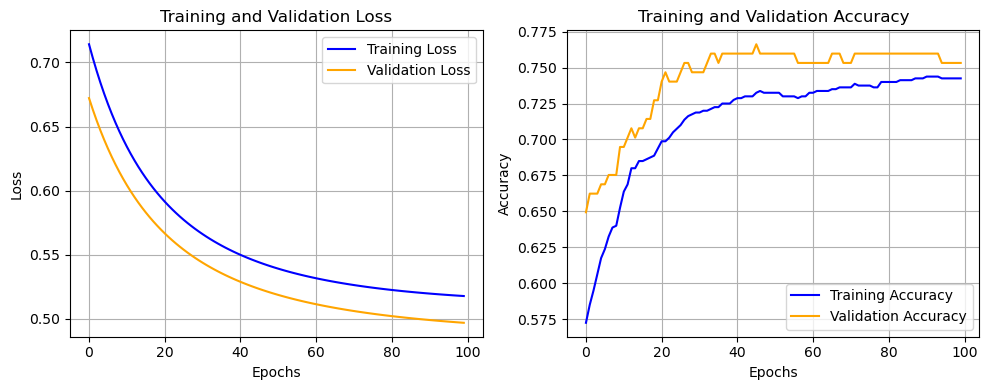

In [19]:
# Plotting Loss and Accuracy
epochs_range = range(num_epochs)

# Loss Plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
plt.plot(epochs_range, val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('FinalModel.png')
plt.show()